<a href="https://colab.research.google.com/github/npipal/MoneyBall/blob/main/MoneyBall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('/content/baseball.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


#H1 Inspecting/Cleaning/Removing Data

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   League        1232 non-null   object 
 2   Year          1232 non-null   int64  
 3   RS            1232 non-null   int64  
 4   RA            1232 non-null   int64  
 5   W             1232 non-null   int64  
 6   OBP           1232 non-null   float64
 7   SLG           1232 non-null   float64
 8   BA            1232 non-null   float64
 9   Playoffs      1232 non-null   int64  
 10  RankSeason    244 non-null    float64
 11  RankPlayoffs  244 non-null    float64
 12  G             1232 non-null   int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 144.5+ KB


# Checking for Duplicate Values

In [86]:
df.duplicated().sum()

0

- No duplicates found no need to remove.

In [87]:
#There are some missing data in 4 columns
df.isna().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64

- These columns with missing data are not useful for the target value. So I can remove those. 

# Dropping Unnecessary Columns

In [88]:
df = df.drop(columns = ['Team', 'RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG'])

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   League    1232 non-null   object 
 1   Year      1232 non-null   int64  
 2   RS        1232 non-null   int64  
 3   RA        1232 non-null   int64  
 4   W         1232 non-null   int64  
 5   OBP       1232 non-null   float64
 6   SLG       1232 non-null   float64
 7   BA        1232 non-null   float64
 8   Playoffs  1232 non-null   int64  
 9   G         1232 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 96.4+ KB


- No missing values in this data set

# Checking for Inconsistent Values in Numerical Columns

In [90]:
df.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,G
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,1988.957792,715.081981,715.081981,80.904221,0.326331,0.397342,0.259273,0.198052,161.918831
std,14.819625,91.534294,93.079933,11.458139,0.015013,0.033267,0.012907,0.398693,0.624365
min,1962.000000,463.000000,472.000000,40.000000,0.277000,0.301000,0.214000,0.000000,158.000000
25%,1976.750000,652.000000,649.750000,73.000000,0.317000,0.375000,0.251000,0.000000,162.000000
50%,1989.000000,711.000000,709.000000,81.000000,0.326000,0.396000,0.260000,0.000000,162.000000
75%,2002.000000,775.000000,774.250000,89.000000,0.337000,0.421000,0.268000,0.000000,162.000000
max,2012.000000,1009.000000,1103.000000,116.000000,0.373000,0.491000,0.294000,1.000000,165.000000


- I did not see any values that need to be fixed. They all appear to have plausible values.

# Checking for Inconsistent Values in Object Columns

In [91]:
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols

Index(['League'], dtype='object')

In [92]:
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= League
NL    616
AL    616
Name: League, dtype: int64





- I do not see any inconsistent values in the object columns. 

# Exploring Univariate Visuals for Target (Playoffs) and all Feature Columns

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   League    1232 non-null   object 
 1   Year      1232 non-null   int64  
 2   RS        1232 non-null   int64  
 3   RA        1232 non-null   int64  
 4   W         1232 non-null   int64  
 5   OBP       1232 non-null   float64
 6   SLG       1232 non-null   float64
 7   BA        1232 non-null   float64
 8   Playoffs  1232 non-null   int64  
 9   G         1232 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 96.4+ KB


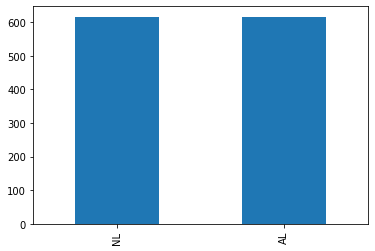

In [94]:
df['League'].value_counts().plot(kind='bar');

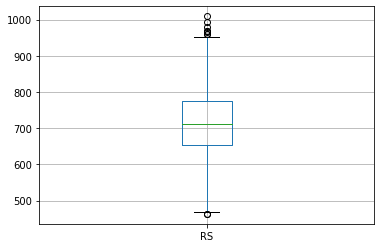

In [95]:
df.boxplot(column='RS')

- A couple of outliers in the data for Runs Scored but everything is plausible

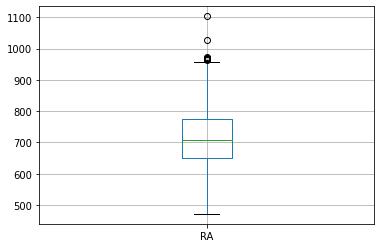

In [96]:
df.boxplot(column='RA')

- A couple of outliers in the data for Runs Allowed but everything is plausible

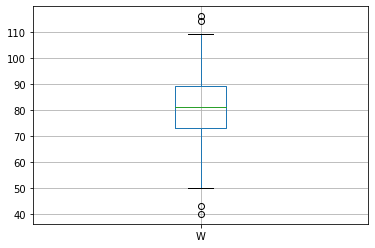

In [97]:
df.boxplot(column='W')

- A couple of outliers in the data for Wins but everything is plausible

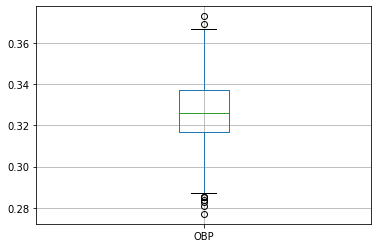

In [98]:
df.boxplot(column='OBP')

- Some outliers in the data for On-Base-Percentage but everything is plausible

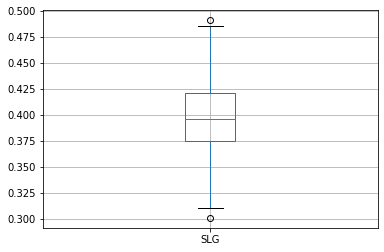

In [99]:
df.boxplot(column='SLG')

- A couple of outliers in the data for Slugging Percentage but everything is plausible

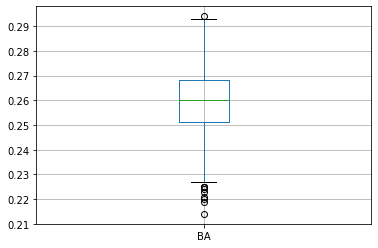

In [100]:
df.boxplot(column='BA')

- Some outliers in the data for Batting Average but everything is plausible

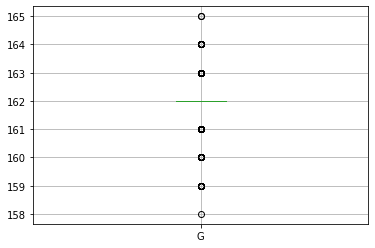

In [101]:
df.boxplot(column='G')

- A couple of outliers in the data for Games but everything is plausible

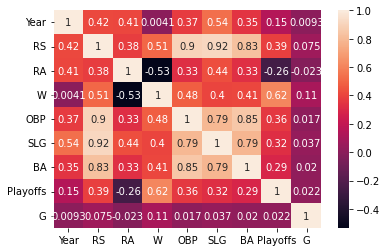

In [102]:
corr = df.corr()

sns.heatmap(corr, annot = True);

- Strong relationship between Playoffs (target) with (features) RS, Wins, OBP, SLG and BA.
- Strong relationship between RS, SLG, OBP, Wins, BA 

# Explanatory Visuals

# How does Batting Average and Slugging Percentage Impact Making the Playoffs

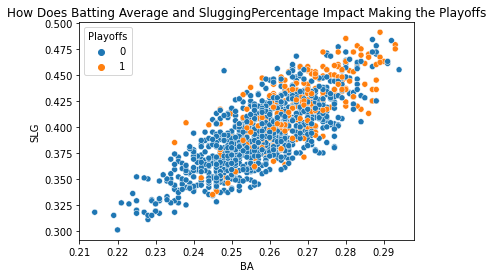

In [103]:
sns.scatterplot(data = df, x = 'BA', y = 'SLG', hue = 'Playoffs').set(title='How Does Batting Average and Slugging Percentage Impact Making the Playoffs');

- After viewing the graph above we can see that teams who have a higher batting average and slugging percentage more often that not have a better chance of making the playoffs. Although there are a few outliers in this case there are teams who did not make the playoffs with a high BA and SLG as well as teams who did make the playoffs with a low BA and SLG. 

# How Does RunsScored and OnBasePercentage Impact Making the Playoffs

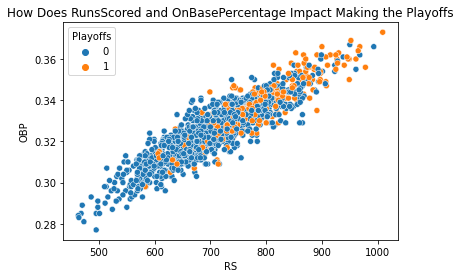

In [104]:
sns.scatterplot(data = df, x = 'RS', y = 'OBP', hue = 'Playoffs').set(title='How Does RunsScored and OnBasePercentage Impact Making the Playoffs');

- After examining the graph we can see that teams who have a higher on-base percentage and total runs scored for the year are more than likely to make the playoffs that given year. Although we do see some outliers on both sides where teams who did make the playoffs but did not score a lot of runs and had a low on base percentage. As well as teams who did not make the playoffs who scored a lot of runs and had a high on-base percentage. 

#H2 Regression Models Pre Processing

In [105]:
# assigning target y and features x
X = df.drop(columns='Playoffs')
y = df['Playoffs']
# train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [106]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

# Use 2 tuples, one for numeric and one for categorical
ohe_tuple = (ohe, cat_selector)
scaler_tuple = (scaler, num_selector)


# Combine the pipelines in a ColumnTransformer with the appropriate column selectors
transformer = make_column_transformer(scaler_tuple, ohe_tuple, remainder='passthrough')

In [107]:
def eval_model(true, pred):
  mae= mean_absolute_error(true, pred)
  mse= mean_squared_error(true, pred)
  rmse=np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE: {mae:,.2f}, \n MSE: {mse:,.2f}, \n RMSE: {rmse:,.2f}, \n R2: {r2:,.2f} ')
# and prints all 4 metrics

#H3 Default Random Forest Model

In [108]:
# Instantiate Model
rf = RandomForestRegressor(random_state = 42)

In [109]:
# Looking at some hyperparameters that seem tunable
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [110]:
# Create and Fit Pipeline
rf_pipe = make_pipeline(transformer, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

#Default Random Forest Model Evaluation

In [111]:
# Obtain evaluation metrics on both train and test sets
print('RF Training RMSE:', np.sqrt(mean_squared_error(y_train, rf_pipe.predict(X_train))))
print('RF Testing RMSE:', np.sqrt(mean_squared_error(y_test, rf_pipe.predict(X_test))))
print('------')
print('RF Training MAE:', np.sqrt(mean_absolute_error(y_train, rf_pipe.predict(X_train))))
print('RF Testing MAE:', np.sqrt(mean_absolute_error(y_test, rf_pipe.predict(X_test))))
print('------')
print('RF Training R2:', r2_score(y_train, rf_pipe.predict(X_train)))
print('RF Testing R2:', r2_score(y_test, rf_pipe.predict(X_test)))

RF Training RMSE: 0.09532412240187849
RF Testing RMSE: 0.2580364164372777
------
RF Training MAE: 0.20667958345334989
RF Testing MAE: 0.3370517706583013
------
RF Training R2: 0.9432542413049043
RF Testing R2: 0.5700558164862841


- With an R2 training score of .94 and a test score of .57 this model has high variance and is overfit

#H4 Hypertuned Random Forest Model

In [112]:
# Hypertuning the random forest model.
rf_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [113]:
# Hyperparameter Testing
rf_params = {'randomforestregressor__max_depth' : [None, 1, 2, 3, 4, 5],
             'randomforestregressor__n_estimators' : [100, 300, 500, 600],
             'randomforestregressor__min_samples_split' : [2, 4]}

In [114]:
# Instantiate the Gridsearch with the Random Forest pipeline
rf_gs = GridSearchCV(rf_pipe, rf_params)

rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                                       ('randomfo

In [115]:
# See which hyperparameters gave the best results
rf_gs.best_params_

{'randomforestregressor__max_depth': 3,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 600}

In [116]:
# Extracting the best version of the model from the gridsearch object
best_rf = rf_gs.best_estimator_

#Hypertuned Random Forest Model Evaluation

In [117]:
# Obtaining the evaluation metrics of the tuned model for both the train and the test sets
print('RF_GS Training RMSE:', np.sqrt(mean_squared_error(y_train, best_rf.predict(X_train))))
print('RF_GS Testing RMSE:', np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))))
print('------')
print('RF_GS Training MAE:', np.sqrt(mean_absolute_error(y_train, best_rf.predict(X_train))))
print('RF_GS Testing MAE:', np.sqrt(mean_absolute_error(y_test, best_rf.predict(X_test))))
print('------')
print('RF_GS Training R2:', r2_score(y_train, best_rf.predict(X_train)))
print('RF_GS Testing R2:', r2_score(y_test, best_rf.predict(X_test)))

RF_GS Training RMSE: 0.21924717649978334
RF_GS Testing RMSE: 0.25936402429469196
------
RF_GS Training MAE: 0.3252794026835862
RF_GS Testing MAE: 0.3483081794040972
------
RF_GS Training R2: 0.6998102950546445
RF_GS Testing R2: 0.5656202746214216


- With an R2 training score of .69 and a test score of .56 is a good fit, but not great.

#H5 Default KNeighborsRegressor Model

In [118]:
# Instantiate Model
knn = KNeighborsRegressor()

In [119]:
# Looking at some hyperparameters that seem tunable
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [120]:
# Create and Fit Pipeline
knn_pipe = make_pipeline(transformer, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                ('kneighborsregressor', KNeighborsRegressor())])

# Default KNeighborsRegressor Model Evaluation

In [121]:
# Obtaining evaluation metrics on both the train and test sets.

print('KNN Training RMSE:', np.sqrt(mean_squared_error(y_train, knn_pipe.predict(X_train))))
print('KNN Testing RMSE:', np.sqrt(mean_squared_error(y_test, knn_pipe.predict(X_test))))
print('------')
print('KNN Training MAE:', np.sqrt(mean_absolute_error(y_train, knn_pipe.predict(X_train))))
print('KNN Testing MAE:', np.sqrt(mean_absolute_error(y_test, knn_pipe.predict(X_test))))
print('------')
print('KNN Training R2:', r2_score(y_train, knn_pipe.predict(X_train)))
print('KNN Testing R2:', r2_score(y_test, knn_pipe.predict(X_test)))

KNN Training RMSE: 0.22215006043359375
KNN Testing RMSE: 0.2835306163179038
------
KNN Training MAE: 0.3269960350316299
KNN Testing MAE: 0.3839304590711675
------
KNN Training R2: 0.6918085067476136
KNN Testing R2: 0.48090123204683133


- With a R2 score of .69 and a test score of .48 this data is a good fit but it could be better. 

#H6 Hypertuned KNeighborsRegressor Model

In [122]:
# Hypertuning the KNeighbors model.
knn_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [123]:
# Hyperparameter Testing
knn_params = {'kneighborsregressor__n_neighbors' : [5, 7, 9, 11],
              'kneighborsregressor__leaf_size' : [5, 10, 15]}

In [124]:
# Instantiate the Gridsearch with the KNN pipeline 
knn_gs = GridSearchCV(knn_pipe, knn_params)

knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                                       ('kneighbo

In [125]:
# See which hyperparameters gave the best results
knn_gs.best_params_

{'kneighborsregressor__leaf_size': 5, 'kneighborsregressor__n_neighbors': 5}

In [126]:
# Extracting the best version of the model from the gridsearch object
best_knn = knn_gs.best_estimator_

#Hypertuned KNeighborsRegressor Model Evaluation

In [127]:
# Obtaining the evaluation metrics of the tuned model for both the train and the test sets
print('KNN_GS Training RMSE:', np.sqrt(mean_squared_error(y_train, best_knn.predict(X_train))))
print('KNN_GS Testing RMSE:', np.sqrt(mean_squared_error(y_test, best_knn.predict(X_test))))
print('------')
print('KNN_GS Training MAE:', np.sqrt(mean_absolute_error(y_train, best_knn.predict(X_train))))
print('KNN_GS Testing MAE:', np.sqrt(mean_absolute_error(y_test, best_knn.predict(X_test))))
print('------')
print('KNN_GS Training R2:', r2_score(y_train, best_knn.predict(X_train)))
print('KNN_GS Testing R2:', r2_score(y_test, best_knn.predict(X_test)))

KNN_GS Training RMSE: 0.22215006043359375
KNN_GS Testing RMSE: 0.2835306163179038
------
KNN_GS Training MAE: 0.3269960350316299
KNN_GS Testing MAE: 0.3839304590711675
------
KNN_GS Training R2: 0.6918085067476136
KNN_GS Testing R2: 0.48090123204683133


- Even with the hypertuned model with the best parameters, the R2 training and test scores did not change very much. 

#H7 Default BaggingRegressor Model

In [128]:
# Instantiate Model
bagreg = BaggingRegressor(random_state = 42)

In [129]:
# Looking at some hyperparameters that seem tunable
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [130]:
# Create and Fit Pipeline
bagreg_pipe = make_pipeline(transformer, bagreg)
bagreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                ('baggingregressor', BaggingRegressor(random_state=42))])

# Default BaggingRegressor Model Evaluation

In [131]:
# Obtaining evaluation metrics on both the train and test sets.
print('BAGREG Training RMSE:', np.sqrt(mean_squared_error(y_train, bagreg_pipe.predict(X_train))))
print('BAGREG Testing RMSE:', np.sqrt(mean_squared_error(y_test, bagreg_pipe.predict(X_test))))
print('------')
print('BAGREG Training MAE:', np.sqrt(mean_absolute_error(y_train, bagreg_pipe.predict(X_train))))
print('BAGREG Testing MAE:', np.sqrt(mean_absolute_error(y_test, bagreg_pipe.predict(X_test))))
print('------')
print('BAGREG Training R2:', r2_score(y_train, bagreg_pipe.predict(X_train)))
print('BAGREG Testing R2:', r2_score(y_test, bagreg_pipe.predict(X_test)))

BAGREG Training RMSE: 0.10999803225315942
BAGREG Testing RMSE: 0.27261361267952455
------
BAGREG Training MAE: 0.2091003197581097
BAGREG Testing MAE: 0.3461288702278312
------
BAGREG Training R2: 0.9244390154701386
BAGREG Testing R2: 0.5201061874617112


- With the R2 training score at .92 and a test score of .52 this model has high variance and is overfit. 

#H8 Hypertuned BaggingRegressor Model

In [132]:
# Hypertuning the bagging regressor model.
bagreg_pipe.get_params()

{'baggingregressor': BaggingRegressor(random_state=42),
 'baggingregressor__base_estimator': None,
 'baggingregressor__bootstrap': True,
 'baggingregressor__bootstrap_features': False,
 'baggingregressor__max_features': 1.0,
 'baggingregressor__max_samples': 1.0,
 'baggingregressor__n_estimators': 10,
 'baggingregressor__n_jobs': None,
 'baggingregressor__oob_score': False,
 'baggingregressor__random_state': 42,
 'baggingregressor__verbose': 0,
 'baggingregressor__warm_start': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transforme

In [133]:
# Hyperparameter Testing
bagreg_params = {'baggingregressor__n_estimators' : [25, 30, 35, 40],
              'baggingregressor__max_features' : [5, 6, 7, 8, 9, 10],
              'baggingregressor__max_samples' : [5, 10, 15, 20, 25]}

In [134]:
# Instantiate the Gridsearch with the BAGREG pipeline 
bagreg_gs = GridSearchCV(bagreg_pipe, bagreg_params)

bagreg_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                                       ('baggingr

In [135]:
# See which hyperparameters gave the best results
bagreg_gs.best_params_

{'baggingregressor__max_features': 10,
 'baggingregressor__max_samples': 20,
 'baggingregressor__n_estimators': 25}

In [136]:
# Extracting the best version of the model from the gridsearch object
best_bagreg = bagreg_gs.best_estimator_

#Hypertuned BaggingRegressor Model Evaluation

In [137]:
# Obtaining the evaluation metrics of the tuned model for both the train and the test sets
print('BAGREG_GS Training RMSE:', np.sqrt(mean_squared_error(y_train, best_bagreg.predict(X_train))))
print('BAGREG_GS Testing RMSE:', np.sqrt(mean_squared_error(y_test, best_bagreg.predict(X_test))))
print('------')
print('BAGREG_GS Training MAE:', np.sqrt(mean_absolute_error(y_train, best_bagreg.predict(X_train))))
print('BAGREG_GS Testing MAE:', np.sqrt(mean_absolute_error(y_test, best_bagreg.predict(X_test))))
print('------')
print('BAGREG_GS Training R2:', r2_score(y_train, best_bagreg.predict(X_train)))
print('BAGREG_GS Testing R2:', r2_score(y_test, best_bagreg.predict(X_test)))

BAGREG_GS Training RMSE: 0.24481462197793483
BAGREG_GS Testing RMSE: 0.27544533009315997
------
BAGREG_GS Training MAE: 0.3452836214198108
BAGREG_GS Testing MAE: 0.36055512754639896
------
BAGREG_GS Training R2: 0.6257149486157335
BAGREG_GS Testing R2: 0.5100848138315976


- With an R2 score of training score of .62 and a test score of .51 this data is a good fit, but not great. 

#H10 Default DecisionTree Model

In [138]:
# Instantiate Model
dectree = DecisionTreeRegressor(random_state=42)

In [139]:
# Looking at some hyperparameters that seem tunable
dectree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [140]:
# Create and Fit Pipeline
dectree_pipe = make_pipeline(transformer, dectree)
dectree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

#Default DecisionTree Model Evaluation

In [141]:
# Obtaining evaluation metrics on both the train and test sets.
print('DECTREE Training RMSE:', np.sqrt(mean_squared_error(y_train, dectree_pipe.predict(X_train))))
print('DECTREE Testing RMSE:', np.sqrt(mean_squared_error(y_test, dectree_pipe.predict(X_test))))
print('------')
print('DECTREE Training MAE:', np.sqrt(mean_absolute_error(y_train, dectree_pipe.predict(X_train))))
print('DECTREE Testing MAE:', np.sqrt(mean_absolute_error(y_test, dectree_pipe.predict(X_test))))
print('------')
print('DECTREE Training R2:', r2_score(y_train, dectree_pipe.predict(X_train)))
print('DECTREE Testing R2:', r2_score(y_test, dectree_pipe.predict(X_test)))

DECTREE Training RMSE: 0.0
DECTREE Testing RMSE: 0.34188172937891387
------
DECTREE Training MAE: 0.0
DECTREE Testing MAE: 0.34188172937891387
------
DECTREE Training R2: 1.0
DECTREE Testing R2: 0.24525219522156416


- With the R2 training score being 1.0 and the test score .24 this data has a very high variance and is overfit. 

#H11 Hypertuned Decision Tree Model

In [142]:
# Hypertuning the bagging regressor model.
dectree_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__categories': 'auto',
 'columntransformer__onehotencoder__drop': None,
 'columntransformer__onehotencoder__dtype': numpy.float64,
 'columntransformer__onehotencoder__handle_unknown': 'ignore',
 'columntransformer__onehotencoder__sparse': False,
 'columntransformer__remainde

In [143]:
# Hyperparameter Testing
dectree_params = {'decisiontreeregressor__max_depth' : [None, 1, 2, 3, 4, 5],
              'decisiontreeregressor__min_samples_leaf' : [1, 2, 3, 4, 5],
              'decisiontreeregressor__min_samples_split' : [2, 3, 4, 5, 6]}

In [144]:
# Instantiate the Gridsearch with the BAGREG pipeline 
dectree_gs = GridSearchCV(dectree_pipe, dectree_params)

dectree_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c70d0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07ed0c7ad0>)])),
                                       ('decision

In [145]:
# See which hyperparameters gave the best results
dectree_gs.best_params_

{'decisiontreeregressor__max_depth': 2,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__min_samples_split': 2}

In [146]:
# Extracting the best version of the model from the gridsearch object
best_dectree = dectree_gs.best_estimator_

#Hypertuned DecisionTree Model Evaluation

In [147]:
# Obtaining the evaluation metrics of the tuned model for both the train and the test sets
print('DECTREE_GS Training RMSE:', np.sqrt(mean_squared_error(y_train, best_dectree.predict(X_train))))
print('DECTREE_GS Testing RMSE:', np.sqrt(mean_squared_error(y_test, best_dectree.predict(X_test))))
print('------')
print('DECTREE_GS Training MAE:', np.sqrt(mean_absolute_error(y_train, best_dectree.predict(X_train))))
print('DECTREE_GS Testing MAE:', np.sqrt(mean_absolute_error(y_test, best_dectree.predict(X_test))))
print('------')
print('DECTREE_GS Training R2:', r2_score(y_train, best_dectree.predict(X_train)))
print('DECTREE_GS Testing R2:', r2_score(y_test, best_dectree.predict(X_test)))

DECTREE_GS Training RMSE: 0.24573621425166406
DECTREE_GS Testing RMSE: 0.27610234305612574
------
DECTREE_GS Training MAE: 0.347523486960924
DECTREE_GS Testing MAE: 0.3654821423817536
------
DECTREE_GS Training R2: 0.6228916902664601
DECTREE_GS Testing R2: 0.5077448611816449


- With a R2 training score of .62 and a test score of .50 this data is a good fit but not great. 

#H12 Final Scores Compared

Default Random Forest Model Evaluation:

- RF Training RMSE: 0.09532412240187849
- RF Testing RMSE: 0.2580364164372777
------
- RF Training MAE: 0.20667958345334989
- RF Testing MAE: 0.3370517706583013
------
- RF Training R2: 0.9432542413049043
- RF Testing R2: 0.5700558164862841

Hypertuned Random Forest Model Evaluation:

- RF_GS Training RMSE: 0.21924717649978334
- RF_GS Testing RMSE: 0.25936402429469196
------
- RF_GS Training MAE: 0.3252794026835862
- RF_GS Testing MAE: 0.3483081794040972
------
- RF_GS Training R2: 0.6998102950546445
- RF_GS Testing R2: 0.5656202746214216


Default KNeighborsRegressor Model Evaluation:

- KNN Training RMSE: 0.22215006043359375
- KNN Testing RMSE: 0.2835306163179038
------
- KNN Training MAE: 0.3269960350316299
- KNN Testing MAE: 0.3839304590711675
------
- KNN Training R2: 0.6918085067476136
- KNN Testing R2: 0.48090123204683133



Hypertuned KNeighborsRegressor Model Evaluation:

- KNN_GS Training RMSE: 0.22215006043359375
- KNN_GS Testing RMSE: 0.2835306163179038
------
- KNN_GS Training MAE: 0.3269960350316299
- KNN_GS Testing MAE: 0.3839304590711675
------
- KNN_GS Training R2: 0.6918085067476136
- KNN_GS Testing R2: 0.48090123204683133

Default BaggingRegressor Model Evaluation:

- BAGREG Training RMSE: 0.10999803225315942
- BAGREG Testing RMSE: 0.27261361267952455
------
- BAGREG Training MAE: 0.2091003197581097
- BAGREG Testing MAE: 0.3461288702278312
------
- BAGREG Training R2: 0.9244390154701386
- BAGREG Testing R2: 0.5201061874617112

Hypertuned BaggingRegressor Model Evaluation:

- BAGREG_GS Training RMSE: 0.24481462197793483
- BAGREG_GS Testing RMSE: 0.27544533009315997
------
- BAGREG_GS Training MAE: 0.3452836214198108
- BAGREG_GS Testing MAE: 0.36055512754639896
------
- BAGREG_GS Training R2: 0.6257149486157335
- BAGREG_GS Testing R2: 0.5100848138315976

Default DecisionTree Model Evaluation:

- DECTREE Training RMSE: 0.0
- DECTREE Testing RMSE: 0.34188172937891387
------
- DECTREE Training MAE: 0.0
- DECTREE Testing MAE: 0.34188172937891387
------
- DECTREE Training R2: 1.0
- DECTREE Testing R2: 0.24525219522156416

Hypertuned DecisionTree Model Evaluation:

- DECTREE_GS Training RMSE: 0.24573621425166406
- DECTREE_GS Testing RMSE: 0.27610234305612574
------
- DECTREE_GS Training MAE: 0.347523486960924
- DECTREE_GS Testing MAE: 0.3654821423817536
------
- DECTREE_GS Training R2: 0.6228916902664601
- DECTREE_GS Testing R2: 0.5077448611816449

#H13 Final Evaluation:

- After evaluating all of the models the model with the best fit for the data is the Hypertuned Random Forest Model with the following scores:

Hypertuned Random Forest Model Evaluation:

- RF_GS Training RMSE: 0.21924717649978334
- RF_GS Testing RMSE: 0.25936402429469196
------
- RF_GS Training MAE: 0.3252794026835862
- RF_GS Testing MAE: 0.3483081794040972
------
- RF_GS Training R2: 0.6998102950546445
- RF_GS Testing R2: 0.5656202746214216


- The hyperparamters for this data are 
 - max_depth: 3
 - min_samples_split: 2
 - n_estimators: 600


- I have decided to use this model as my final 'production' model due to the fact that the R2 training and test score ended up being a good fit for the data and was not overfit so this model would yield the most accurate predictions for whether or not a team would make the playoffs. 